In [1]:
import os
from scipy.special import logsumexp

# change to the root folder
os.chdir("..")

from tests.test_zestimation import *

In [2]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

# Quasar Redshift Normalization Improvement

$$
x  \leftarrow x / \bar{x}(z_{\mathrm{QSO}})
$$

$$
\bar{x}(z_{\text{QSO}}) =  \mathrm{median} [ x(\mathrm{rs}_{z_{\text{QSO}}}(\lambda)\in [1176 \AA , 1256 \AA])  ].
$$


In our previous paper (Eq 8, https://arxiv.org/pdf/2006.07343.pdf), we divided the median of the Lyman alpha peak in the restframe for normalization. This strategy highly depends on the behaviour of the Lyman alpha peak. It means if the peak behaves strangely, then the normalization would be slightly off, and the likelihood calculation would not be totally accurate. This not only applies to normalizing the Lya peak. Normalizing at any given region would have the same issue (though using an emission-free region would be less problemsome). 

Although the learned Gaussian process model should have all kinds of normolization scenarios embedded in its covariance, it's hard to say the GP has the ability to ensure the normalization factor is accurate for each new quasar spectrum given the nature of emission peaks is variable.

One proposed idea is to marginalize out the uncertainty of the normalization factor. Suppose an uncertainty is associated with computing $\mathrm{median} [ x(\mathrm{rs}_{z_{\text{QSO}}}(\lambda)\in [1176 \AA , 1256 \AA])$, the uncertainty shouldn't exceed min and max values of $x(\mathrm{rs}_{z_{\text{QSO}}}(\lambda)\in [1176 \AA , 1256 \AA])$; otherwise, the normalized spectrum won't fit to the model.

We can reframe the likelihood to include marginalizing the normalization factor

$$
p(\tilde{y} = x \mid D^0, z_\mathrm{QSO})
= 
\int_{x_{min}}^{x_{max}}
\mathcal{N}( \frac{x}{x'(z_\mathrm{QSO})}; \mu \circ \mathrm{rs}_{z\mathrm{QSO}}, K \circ \mathrm{rs}_{z_{QSO}}
+ \frac{K_N}{x'(z_\mathrm{QSO})^2})
p(x' | D^0, z_\mathrm{QSO}) \mathrm{d}x'
$$

where

$$
x_{min} = \mathrm{min} [ x(\mathrm{rs}_{z_{\text{QSO}}}(\lambda)\in [1176 \AA , 1256 \AA])  ],
$$

$$
x_{max} = \mathrm{max} [ x(\mathrm{rs}_{z_{\text{QSO}}}(\lambda)\in [1176 \AA , 1256 \AA])  ].
$$

It means we want to sum over the likelihoods from all possible normalization factors within the range of Lyman alpha peak (of course, you can choose another normalization region you want).

In [3]:
# Model setup: read a spectrum, setup GP model
# ----
# read a spectrum from SDSS DR12
nspec = 59
# path to the learned GP model
learned_file = "data/dr12q/processed/learned_zqso_only_model_outdata_full_dr9q_minus_concordance_norm_1176-1256.mat"

# filenames is an array for a list of spectra, and we take one of them here
filename = filenames[nspec]

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# make sure the file exists
assert os.path.exists(filename) == True

# read the raw spectrum
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

# Initialize the model parameters
params = ZParameters()
z_qso_samples = ZSamples(params)

# load the model
z_qso_gp = ZGPMAT(
    params,
    z_qso_samples,
    learned_file=learned_file,
)

In [4]:
# Baseline model: normalizing with median of the Lyman peak
# ----
# 10,000 test redshifts, from 2 ~ 5, linearly spacing
# For high-z spectra, sometimes they go above 5.
# You can set the maximum to be 7.
test_redshifts = np.linspace(2, 5, 10000)

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True, # default normalization is the median flux of [1176A, 1256A] at rest-frame 
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred = test_redshifts[idx]
print(z_pred)

2.3954395439543954


In [5]:
# Baseline model: normalizing with median of the Lyman peak. But this time we only do it at a small region
#                 [z_true - delta z, z_true + delta z], so we can zoom in into the likelihood curve around the true
#                 value.
# ----
dz = np.abs(z_pred - z_qsos[nspec])

test_redshifts = np.linspace(z_qsos[nspec] - 2*dz, z_qsos[nspec] + 2*dz, 100)

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred_m = test_redshifts[idx]
print(z_pred_m)

2.3954858316922296


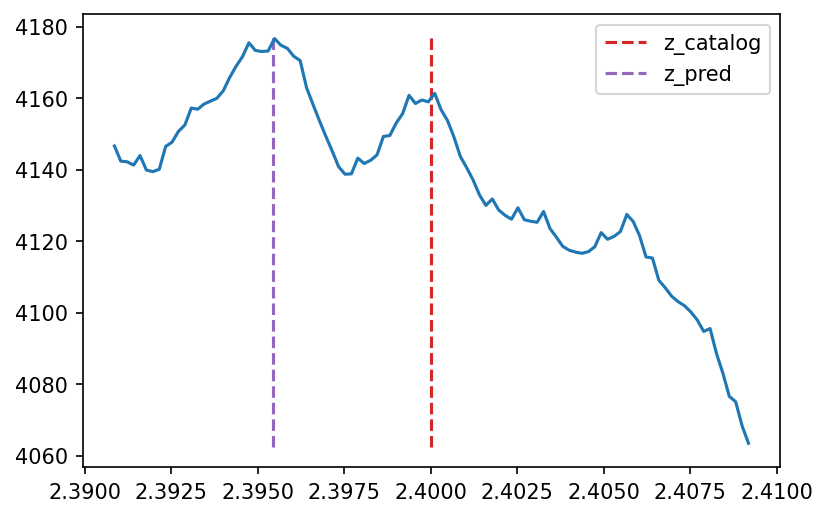

In [6]:
# plot the likelihood curve, inclding the locations of GP prediction and the true catalog values
plt.plot(test_redshifts, sample_log_likelihoods)
plt.vlines(z_qsos[nspec], min(sample_log_likelihoods) - 1, max(sample_log_likelihoods) + 1, ls='--', color="C3", label="z_catalog")
plt.vlines(z_pred, min(sample_log_likelihoods) - 1, max(sample_log_likelihoods) + 1, ls='--', color="C4", label="z_pred")
plt.legend()

In [7]:
# Imrpoved model: marginzing over the uncertainty of normalization factor. We don't know the uncertainty,
#                 so we simply sum over the lower bound nad upper bounds, which are the minimum and maximum
#                 within the [1176A, 1256A] flux region.
# ---
# sample the reshift values the same as the previous model
test_redshifts = np.linspace(z_qsos[nspec] - 2*dz, z_qsos[nspec] + 2*dz, 100)

sample_log_likelihoods_m = []
list_sample_norm_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )

    # Modified Normalization:
    # ----
    # We cannot rely on the default normalization anymore, so we need to renormalize
    # the flux and then re-assign the values to the z_qso_gp model:
    #
    #  >>  z_qso_gp.y = y_old / norm     # (normalizing the flux)
    #  >>  z_qso_gp.v = v_old / norm**2  # (normalizing the variance)
    #
    # before that we need to determin the `norm`, the new normalization factor ...

    # manually normalize the flux
    ind = (z_qso_gp.x >= z_qso_gp.params.normalization_min_lambda) & (
           z_qso_gp.x <= z_qso_gp.params.normalization_max_lambda)
    # sampling normalization range
    min_norm, median_norm, max_norm = np.quantile(z_qso_gp.y[ind], [0.05, 0.5, 0.95])
    y_old = z_qso_gp.y
    v_old = z_qso_gp.v

    sample_norm_log_likelihoods = []

    # normalize all possible values within the [1176, 1256] range
    for norm in z_qso_gp.y[ind]:
# uncomment this and comment the above line if you prefer to sample the linearly spacing 90% prior volume
#     for norm in np.linspace(min_norm, max_norm, 100): 
        z_qso_gp.y = y_old / norm
        z_qso_gp.v = v_old / norm**2

        # At the current stage, we don't consider the prior. The prior of normalization factor is
        # assumed to be uniform.
        sample_norm_log_likelihoods.append(z_qso_gp.log_model_evidence() ) #+ np.log(prior))

    # [get the likelihood value]
    sample_log_likelihoods_m.append(logsumexp(sample_norm_log_likelihoods))
    
    list_sample_norm_log_likelihoods.append(sample_norm_log_likelihoods)

In [8]:
# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods_m)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred_norm = test_redshifts[idx]
print("zCatalog, zPred, zPredNorm", z_qsos[nspec], z_pred, z_pred_norm)

zCatalog, zPred, zPredNorm 2.40002203 2.3954395439543954 2.3960412845462424


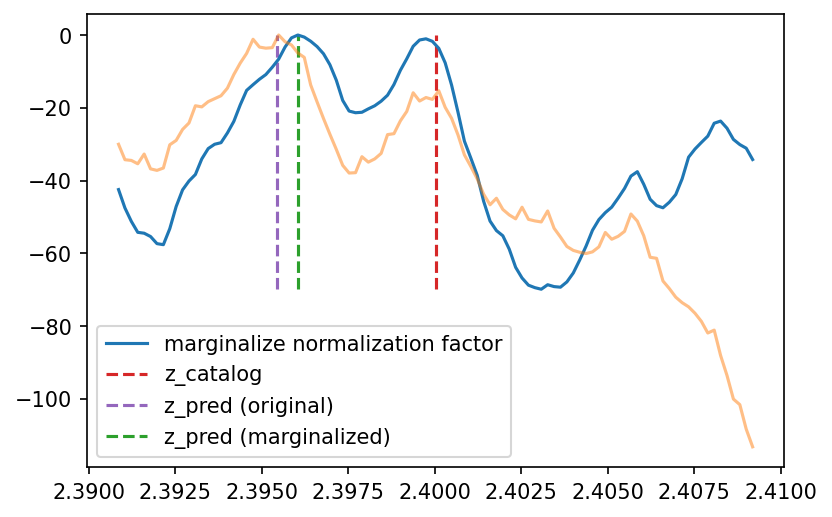

In [9]:
# the comparison between the baseline model and the imrpoved one. The likelihood curve is apparently imrproved
# with the new method, but the small biased is still existed, which is visible in the double peak structure in the
# likelihood curve,
plt.plot(test_redshifts, sample_log_likelihoods_m - np.max(sample_log_likelihoods_m), label="marginalize normalization factor")
plt.plot(test_redshifts, sample_log_likelihoods - np.max(sample_log_likelihoods), alpha=0.5, color="C1")
plt.vlines(
    z_qsos[nspec],
    min(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    max(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    ls='--',
    color="C3",
    label="z_catalog"
)
plt.vlines(
    z_pred,
    min(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    max(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    ls='--',
    color="C4",
    label="z_pred (original)"
)
plt.vlines(
    z_pred_norm,
    min(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    max(sample_log_likelihoods_m - np.max(sample_log_likelihoods_m)),
    ls='--',
    color="C2",
    label="z_pred (marginalized)"
)

plt.legend()

In [10]:
print("(zCatalog - zPred) / zCatalog = {:.3g}".format((z_qsos[nspec] - z_pred) / z_qsos[nspec]))
print("(zCatalog - zPredNorm) / zCatalog = {:.3g}".format((z_qsos[nspec] - z_pred_norm) / z_qsos[nspec]))

(zCatalog - zPred) / zCatalog = 0.00191
(zCatalog - zPredNorm) / zCatalog = 0.00166


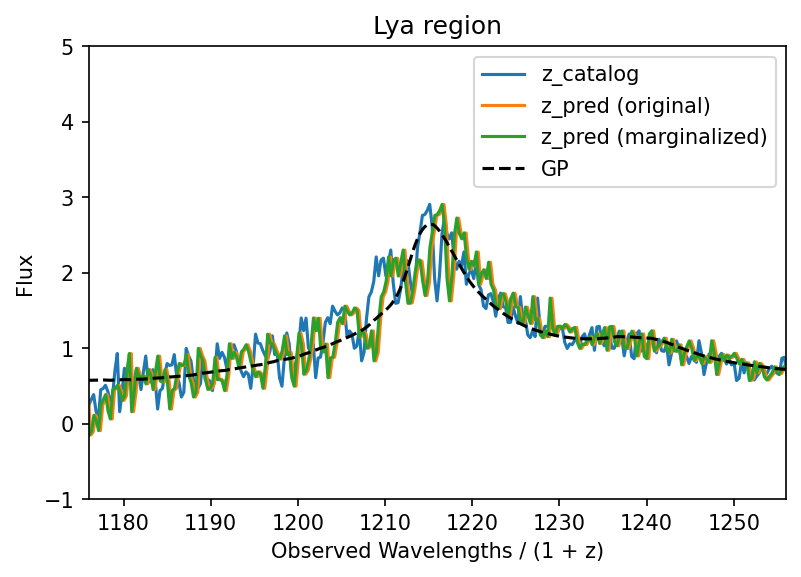

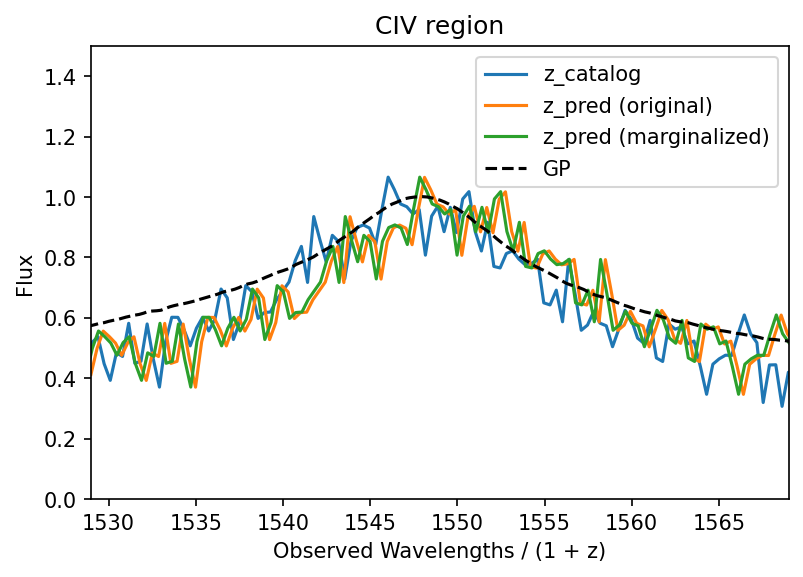

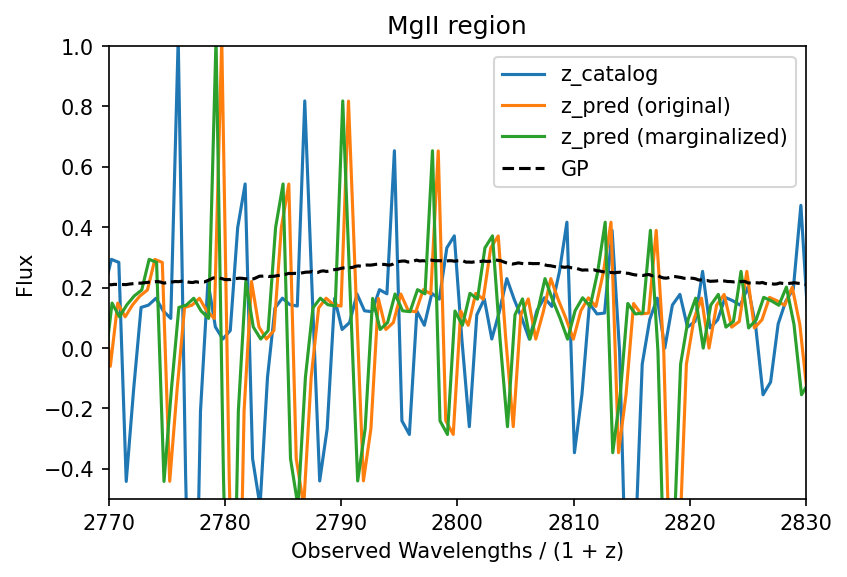

In [11]:
# Overlapping the GP model with the spectrum
# Let's try several wavelegths and also plot the emission lines
# We can try different values of z to see which one makes sense

# Lyman alpha peak region
# ----
for z in (z_qsos[nspec], z_pred, z_pred_norm):
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z,
        normalize=True,
        build_model=True,
    )
    plt.plot(z_qso_gp.x, z_qso_gp.y)

# plot the GP model to help measure the z
plt.title("Lya region")
plt.plot(z_qso_gp.rest_wavelengths, z_qso_gp.mu, label="GP", color="k", ls="--")
plt.ylim(-1, 5)
plt.xlim(1176, 1256)
plt.xlabel("Observed Wavelengths / (1 + z)")
plt.ylabel("Flux")
plt.legend(["z_catalog", "z_pred (original)", "z_pred (marginalized)", "GP"])

plt.show()

# CIV peak region
# ----
for z in (z_qsos[nspec], z_pred, z_pred_norm):
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z,
        normalize=True,
        build_model=True,
    )
    plt.plot(z_qso_gp.x, z_qso_gp.y)

# plot the GP model to help measure the z
plt.title("CIV region")
plt.plot(z_qso_gp.rest_wavelengths, z_qso_gp.mu, label="GP", color="k", ls="--")
plt.ylim(0, 1.5)
plt.xlim(1549 - 20, 1549 + 20)
plt.xlabel("Observed Wavelengths / (1 + z)")
plt.ylabel("Flux")
plt.legend(["z_catalog", "z_pred (original)", "z_pred (marginalized)", "GP"])

plt.show()

# MgII peak region
# ----
for z in (z_qsos[nspec], z_pred, z_pred_norm):
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z,
        normalize=True,
        build_model=True,
    )
    plt.plot(z_qso_gp.x, z_qso_gp.y)

# plot the GP model to help measure the z
plt.title("MgII region")
plt.plot(z_qso_gp.rest_wavelengths, z_qso_gp.mu, label="GP", color="k", ls="--")
plt.ylim(-0.5, 1)
plt.xlim(2800 - 30, 2800 + 30)
plt.xlabel("Observed Wavelengths / (1 + z)")
plt.ylabel("Flux")
plt.legend(["z_catalog", "z_pred (original)", "z_pred (marginalized)", "GP"])

plt.show()